First attempt at preprocessing a corpus of data. The planned steps and goal are as follows:

1. Generate a random test corpus of $n$ documents with $\mathcal{N}(\mu,\sigma)$ phrases of length $\mathcal{N}(\nu, \tau)$.
2. Process the corpus into sentences using a tokenizer (can be extended with other preprocessing).
3. Design and test a data structure to store the processed data.
4. Show a mock classification process using randomly generated features.

Goal: Create a working data format that can represent the data, and is flexible and suitable for machine learning purposes.

In [2]:
import random
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate
import nltk.data
from sklearn.metrics import confusion_matrix, precision_score, recall_score

nltk.download('punkt')
np.set_printoptions(precision=2)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tommy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1 Generating a corpus to test with

In [3]:
n = 10
mu = 80; sigma = 25
nu = 15; tau = 3

In [4]:
with open('test_words.txt') as f:
    words = [x.strip() for x in f.readlines()]
    
print(words[:10])
print(words[-10:])
print(random.sample(words, 10))

['aardvark', 'Aarhus', 'Aaron', 'ABA', 'Ababa', 'aback', 'abacus', 'abalone', 'abandon', 'abase']
['zooplankton', 'Zorn', 'Zoroaster', 'Zoroastrian', 'zounds', "z's", 'zucchini', 'Zulu', 'Zurich', 'zygote']
['Balkan', 'bicker', 'competition', 'aldehyde', 'papyri', 'Gettysburg', 'elephant', 'slippage', 'Skopje', 'Eli']


In [5]:
def make_sentence(strings):
    if random.random() < 0.5:
        strings = insert_comma(strings)
        
    sentence = ' '.join(strings) + '.'
    return sentence[0].capitalize() + sentence[1:]


def insert_comma(strings):
    pos = random.randint(0, len(strings)-2)
    return [s + ',' if i == pos else s for i, s in enumerate(strings[:-1])]


corpus = [' '.join([make_sentence(random.sample(words, int(random.gauss(nu, tau))))
                    for _ in range(int(random.gauss(mu, sigma)))])
                    for _ in range(n)]
    
print('Generated {} documents of lengths {}.'.format(len(corpus), [len(d) for d in corpus]))
print('Mean document length: {}\n\n'.format(sum([len(d) for d in corpus])/n)) 

print('Example text:\n')
print(corpus[0][:1000] + '...')

Generated 10 documents of lengths [7568, 8043, 10237, 11036, 11790, 8357, 12760, 10241, 14248, 10660].
Mean document length: 10494.0


Example text:

Julie Haas Linnaeus turnover, Seward union bereft boyar peephole drumlin circumcircle. Perle Pablo PBS dynamo causal reciprocal Atwater patroness satisfaction centrifugate mastic drastic downstairs sowbug expert capacity matriculate turnoff. Idyll Celt hillock surmise pencil frothy calorimeter hidden slugging adapt band insight lubricious radium. McDonnell paramagnetic ketchup half profession transposition Blythe Bette, teahouse Yucatan library humanitarian diagrammed dumbbell impost. Hydrocarbon stone concoct rhombus conscience sable burgess bleat mutt snipe longue Freya assumption Thailand wingspread. Poll, Sherlock praise tangerine Andes pyrophosphate Benedikt emendable hubcap trailhead. Mexican perpetrate Cornwall hairspring emblem McDougall seminal compulsory twit famous stearate minimax factorial naughty Pentecost acquaint deflater.

# 2 Preprocessing 

Creating sentences is easy enough with a pre-trained tokenizer.

In [6]:
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
data = sent_detector.tokenize_sents(corpus)

# 3 Indexing the data

The sentences are stored as a column in a pandas DataFrame. The index contains a level describing which document the sentence is from, and a level giving the sentence level. The DataFrame can be extended with columns describing features, otherwise extracted or processed information, or can broadcast to other DataFrames if a different coding is preferable.

<i>If you've never used a MultiIndex DataFrame before, the [docs](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html) give a good introduction to the concept.</i> 

In [7]:
def c(x):
    return list(chain.from_iterable(x))

indices = c([[(j,i)  
            for i, _ in enumerate(data[j])]      
            for j, _ in enumerate(data)])

index = pd.MultiIndex.from_tuples(indices, names=['Document', 'Sentence'])

df = pd.DataFrame(c(data), index=index, columns=['Text'])

print(indices[:3] + indices[-3:], '\n')
print(index, '\n')
print(df, '\n')

[(0, 0), (0, 1), (0, 2), (9, 89), (9, 90), (9, 91)] 

MultiIndex([(0,  0),
            (0,  1),
            (0,  2),
            (0,  3),
            (0,  4),
            (0,  5),
            (0,  6),
            (0,  7),
            (0,  8),
            (0,  9),
            ...
            (9, 82),
            (9, 83),
            (9, 84),
            (9, 85),
            (9, 86),
            (9, 87),
            (9, 88),
            (9, 89),
            (9, 90),
            (9, 91)],
           names=['Document', 'Sentence'], length=898) 

                                                                Text
Document Sentence                                                   
0        0         Julie Haas Linnaeus turnover, Seward union ber...
         1         Perle Pablo PBS dynamo causal reciprocal Atwat...
         2         Idyll Celt hillock surmise pencil frothy calor...
         3         McDonnell paramagnetic ketchup half profession...
         4         Hydrocarbon stone c

let's generate some random data to populate the columns.

In [8]:
df['Stat 1'] = [random.random() * 2 - 1 for _ in df.T]

x = pd.DataFrame([[random.random() * 2 - 1 for _ in range(3)] for _ in df.T], \
                             columns=['Stat {}'.format(i) for i in range(2,5)])

df = pd.concat([df,
                x.set_index(df.index)],
                axis=1)

df['Count'] = [random.randint(0,10) for _ in df.T]
df['Category'] = [random.choice(['A', 'B', 'C', 'D']) for _ in df.T]

print(df)

                                                                Text  \
Document Sentence                                                      
0        0         Julie Haas Linnaeus turnover, Seward union ber...   
         1         Perle Pablo PBS dynamo causal reciprocal Atwat...   
         2         Idyll Celt hillock surmise pencil frothy calor...   
         3         McDonnell paramagnetic ketchup half profession...   
         4         Hydrocarbon stone concoct rhombus conscience s...   
...                                                              ...   
9        87        Antic terrific giddap horsefly prom, Boise esp...   
         88        Recovery jugate fireboat Calder mercenary Pare...   
         89        Immanent phosphorous walkie, Hercules glacial ...   
         90        Peril knit precise magnum octet firewood bulbo...   
         91        Herbert mitosis, leek airfare illegitimate wri...   

                     Stat 1    Stat 2    Stat 3    Stat 4  Coun

Some examples of sorting and slicing operations that can be done.

In [9]:
# Scrambling and resorting the DF
df = df.sort_values('Text')
print('\nSorted alphabetically: ', df)

df = df.sort_values('Sentence')
print('\nSorted by sentence number: ', df)

df = df.loc[df['Text'].str.len().sort_values().index]
print('\n Sorted by string length: ', df)

df = df.sort_values(['Document', 'Sentence'])
print('\nResorted by index: ', df)

print('\nFirst sentence of each document (index removed): \n', 
      df['Text'].xs(0, level='Sentence')) # use drop=False to retain the 'Sentence' index column

print('\nLast sentence of each document: \n',
      df['Text'].groupby('Document').tail(1))

print('\nFirst three sentences of each document: \n',
      df['Text'].loc[(slice(None), slice(0,3)), :])

print('\nStats on a random document: \n',
     df.xs(random.randint(0,df.index.levshape[0]-1), level='Document').describe())

print("\n Columns 'Stat 1' and 'Stat 2' of Document 3: \n",
     df.loc[(slice(3,3), slice(None)), ['Stat 1', 'Stat 2']]) # retain the index
#      df.loc[(3, slice(None))][['Stat 1', 'Stat 2']]) # or not 
#      df.xs(3, level='Document', drop=False)[['Stat 1', 'Stat 2']]) # or specify with drop=False


Sorted alphabetically:                                                                  Text  \
Document Sentence                                                      
6        20        Aback rectify Norway combinatoric proverb hero...   
         61        Abdomen margin highball Frenchmen curtain expl...   
         96        Aberdeen Avernus tag menial duffel calve lacus...   
2        12        Aboriginal cartilage einsteinium philharmonic ...   
7        29        Above pomegranate ignoramus meticulous medic a...   
...                                                              ...   
8        111       Yellowknife equidistant schoolmaster Geminid K...   
         67        Yesterday Lamar Mary hasty filth riot kidnap C...   
6        77        Yokuts Smythe Promethean acerbic Hades raise b...   
8        88        Zagreb samurai yarmulke Chinook pout Marceau i...   
2        63        Zambia ambiguity axe magnum Lopez gist thresh ...   

                     Stat 1    Stat 2 

# 4 Mock classification

A simple classification label can be assigned by calculating the sum of the columns and assigning a label based on if the value is positive or negative. 

In [64]:
import time
import random

for i in range(10):
    start_time = time.time()
    [random.randrange(10**8,10**9) for _ in range(10000)]
    print(time.time()-start_time)
    

0.011995792388916016
0.011999368667602539
0.012001752853393555
0.011998176574707031
0.012000799179077148
0.011999845504760742
0.01199960708618164
0.012000560760498047
0.011998414993286133
0.012001276016235352


## Generating labels

Only a single label is assigned here, but can easily be extended to multiple labels per instance.

In [9]:
def mock_classification(df, labels):
    
    features = ['Stat {}'.format(i) for i in range(1,5)]
    
    df['Stat Sum'] = df[features].sum(axis=1)
    df['Max Stat'] = df[features].idxmax(axis=1)

    df['Assigned Label'] = df['Max Stat'].map(labels).where(df['Stat Sum'] > 1).fillna('Unlabeled')

    return df

In [10]:
labels = {
    'Stat 1': 'P',
    'Stat 2': 'I',
    'Stat 3': 'C',
    'Stat 4': 'O',
    'Other value': 'Unlabeled'
}

df['True Label'] = random.choices(list(labels.values()), 
                                  weights=[0.05]*4 + [0.8], k=len(df))
df = mock_classification(df, labels)

df.to_csv('test_corpus_data.csv')

## Generating results

Lastly, plot the results and generate a confusion matrix and average P/R metrics over the classification. These metrics are more complicated for multi-label problems (if multiple P, I etc. can be assigned), but I won't explore that further here.

80.0% of instances were labeled.
+----------------+-----+-----+-----+-----+-------------+
|                |   P |   I |   C |   O |   Unlabeled |
|----------------+-----+-----+-----+-----+-------------|
| Assigned Label |  34 |  41 |  34 |  53 |         629 |
| True Label     |  43 |  48 |  41 |  40 |         619 |
+----------------+-----+-----+-----+-----+-------------+


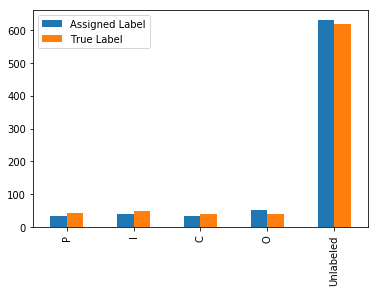

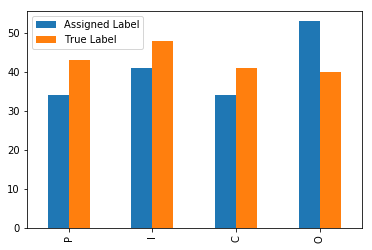

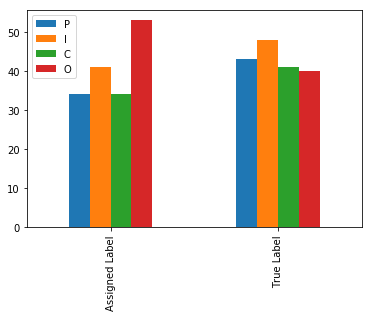

In [11]:
counts = pd.DataFrame(df['Assigned Label'].value_counts()) \
           .join(df['True Label'].value_counts()).fillna(0).T[labels.values()]

print('{}% of instances were labeled.'
      .format(round(100*counts['Unlabeled']['Assigned Label'] / counts.T['Assigned Label'].sum())))

print(tabulate(counts, headers='keys', tablefmt='psql'))

counts.T.plot.bar()
counts.drop('Unlabeled',axis=1).T.plot.bar()
counts.drop('Unlabeled', axis=1).plot.bar()

plt.show()

In [12]:
results = [df['True Label'], df['Assigned Label']]

cm = confusion_matrix(*results)
cm_tab = pd.DataFrame(cm, columns=labels.values(), index=labels.values())

h = ['Assigned/True'] + cm_tab.columns.tolist()
print(tabulate(cm_tab, headers=h, tablefmt= 'psql'))

print("\nAverage precision: \n",
      precision_score(df['True Label'], df['Assigned Label'], average="macro"))

print("\nAverage recall: \n",
      recall_score(df['True Label'], df['Assigned Label'], average="macro"))

# mcm = multiclass_confusion_matrix(*results) # more complicated for the multi-label case.

+-----------------+-----+-----+-----+-----+-------------+
| Assigned/True   |   P |   I |   C |   O |   Unlabeled |
|-----------------+-----+-----+-----+-----+-------------|
| P               |   4 |   0 |   4 |   4 |          29 |
| I               |   0 |   1 |   2 |   1 |          44 |
| C               |   0 |   3 |   0 |   3 |          34 |
| O               |   0 |   1 |   1 |   2 |          39 |
| Unlabeled       |  30 |  36 |  46 |  24 |         483 |
+-----------------+-----+-----+-----+-----+-------------+

Average precision: 
 0.1937492729458296

Average recall: 
 0.18903934568988398


# Other resources found on the way

https://www.tutorialspoint.com/opennlp/opennlp_tokenization.htm

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.multilabel_confusion_matrix.html#sklearn.metrics.multilabel_confusion_matrix